In [5]:
##tools

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [6]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [8]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [10]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [11]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [13]:
tavily.invoke("Provide me the recent AI news?")

[{'title': 'Artificial Intelligence News - ScienceDaily',
  'url': 'https://www.sciencedaily.com/news/computers_math/artificial_intelligence/',
  'content': 'Artificial Intelligence News\n\nTop Headlines\n\nLatest Headlines\n\nEarlier Headlines\n\nTuesday, April 8, 2025\n\nThursday, April 3, 2025\n\nThursday, March 27, 2025\n\nWednesday, March 26, 2025\n\nTuesday, March 25, 2025\n\nWednesday, March 19, 2025\n\nTuesday, March 18, 2025\n\nMonday, March 17, 2025\n\nThursday, March 6, 2025\n\nWednesday, March 5, 2025\n\nTuesday, March 4, 2025\n\nWednesday, February 26, 2025\n\nTuesday, February 25, 2025\n\nFriday, February 21, 2025\n\nThursday, February 20, 2025 [...] Wednesday, February 19, 2025\n\nThursday, February 13, 2025\n\nMonday, February 10, 2025\n\nMonday, February 3, 2025\n\nWednesday, January 29, 2025\n\nTuesday, January 28, 2025\n\nMonday, January 27, 2025\n\nTuesday, January 21, 2025\n\nThursday, January 16, 2025\n\nWednesday, January 15, 2025\n\nTuesday, January 14, 2025\n\n

In [14]:
##Combine all these tools in the list
tools=[arxiv,wiki,tavily]

In [16]:
## Initilaize the LLM model
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-qwq-32b")

In [17]:
llm.invoke("What is AI")

AIMessage(content='\n<think>\nOkay, the user is asking "What is AI?" so I need to explain it in a straightforward way. Let me start by defining AI as a branch of computer science. I should mention that it\'s about creating machines that can perform tasks requiring human-like intelligence. Maybe include some examples like problem-solving or learning from data. Oh, right, it\'s important to note the goal of AI is to simulate human intelligence. \n\nWait, maybe I should break it down into key components. The user might benefit from knowing the main areas of AI: machine learning, natural language processing, computer vision. I should explain each briefly. Also, different types of AI: reactive machines, limited memory, theory of mind, self-aware (though the last two are more theoretical). \n\nApplications are crucial here. People relate to real-world uses like voice assistants, recommendation systems, self-driving cars. Maybe mention how AI processes data and learns from it through algorith

In [18]:
llm_with_tools=llm.bind_tools(tools=tools)

In [19]:
llm_with_tools.invoke("What is the IPL match today")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_t3nx', 'function': {'arguments': '{"query": "IPL match today live score"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 261, 'prompt_tokens': 354, 'total_tokens': 615, 'completion_time': 0.596065503, 'prompt_time': 0.018595776, 'queue_time': 0.26861615499999997, 'total_time': 0.614661279}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_fbb7e6cc39', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--097764fa-e6b5-4a29-99bb-4ecff644c433-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'IPL match today live score'}, 'id': 'call_t3nx', 'type': 'tool_call'}], usage_metadata={'input_tokens': 354, 'output_tokens': 261, 'total_tokens': 615})

## WorkFlow 

In [20]:
##State Schema

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage ##Human message or AI message
from typing import Annotated ## labelling
from langgraph.graph.message import add_messages ## Reducers in Langgraph

In [22]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]


In [23]:
from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

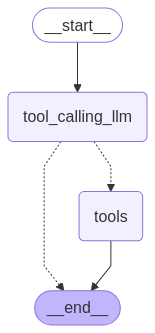

In [26]:
def tool_calling_llm(state:State):\
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

##Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools",END)

graph = builder.compile()

#View
display(Image(graph.get_graph().draw_mermaid_png()))


In [29]:
messages=graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_qksg)
 Call ID: call_qksg
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [31]:
messages=graph.invoke({"messages":"Hello Im Ashen and please tell me the recent paper on Quantum Computing"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello Im Ashen and please tell me the recent paper on Quantum Computing
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_d0md)
 Call ID: call_d0md
  Args:
    query: Quantum Computing
================================= Tool Message =================================
Name: arxiv

Published: 2022-08-01
Title: The Rise of Quantum Internet Computing
Authors: Seng W. Loke
Summary: This article highlights quantum Internet computing as referring to
distributed quantum computing over the quantum Internet, analogous to
(classical) Internet computing involving (classical) distributed computing over
the (classical) Internet. Relevant to quantum Internet computing would be areas
of study such as quantum protocols for distributed nodes using quantum
information for computations, qua


In [ ]:
##Option - Second Method

def tool_calling_llm(state:State):\
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

#build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

##Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")

graph = builder.compile()



In [33]:
messages=graph.invoke({"messages":"What is the recent AI news and please tell me the recent paper on Quantum Computing"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI news and please tell me the recent paper on Quantum Computing
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zwfj)
 Call ID: call_zwfj
  Args:
    query: recent AI news
  arxiv (call_tcna)
 Call ID: call_tcna
  Args:
    query: recent quantum computing papers
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The latest AI news we announced in March - Google Blog", "url": "https://blog.google/technology/ai/google-ai-updates-march-2025/", "content": "The latest AI news we announced in March\n\nApr 04, 2025\n\n[[read-time]] min read\n\nHere’s a recap of some of our biggest AI updates from March, including Gemini 2.5 Pro, expanded access to AI Overviews, the release of AI Mode and more.\n\nGeneral summary [...] March was all about e

In [ ]:
import streamlit as st

# --- Place your tool and graph setup code here ---
# For example, from your notebook:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from typing import Annotated


# --- Tool setup (from your notebook) ---
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

tavily = TavilySearchResults()

tools = [arxiv, wiki, tavily]

# --- LLM setup (from your notebook) ---
llm = ChatGroq(model="qwen-qwq-32b")
llm_with_tools = llm.bind_tools(tools=tools)

# --- LangGraph state and graph setup ---
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile()
# --- End of backend setup ---

# --- Streamlit UI ---
st.set_page_config(page_title="Multi-Tool AI Chatbot", page_icon="🤖")
st.title("🤖 Multi-Tool AI Chatbot")
st.caption("Ask about AI news, research papers, Wikipedia topics, and more!")

# Initialize chat history in session state
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display chat history
for msg in st.session_state.messages:
    role = "user" if msg["role"] == "human" else "assistant"
    with st.chat_message(role):
        st.markdown(msg["content"])

# User input box
if prompt := st.chat_input("Type your message and press Enter..."):
    # Add user message to history
    st.session_state.messages.append({"role": "human", "content": prompt})
    with st.chat_message("user"):
        st.markdown(prompt)

    # Prepare conversation for the graph
    state = {"messages": st.session_state.messages}
    # Run the LangGraph
    response = graph.invoke(state)
    # Extract assistant's message(s)
    new_messages = response["messages"][len(st.session_state.messages):]  # Only new messages

    # Add and display assistant responses
    for msg in new_messages:
        st.session_state.messages.append({"role": "assistant", "content": getattr(msg, "content", str(msg))})
        with st.chat_message("assistant"):
            st.markdown(getattr(msg, "content", str(msg)))


2025-05-04 22:52:39.272 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 22:52:39.326 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 22:52:42.562 
  command:

    streamlit run c:\Users\Acer\Desktop\LangGraph\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-04 22:52:42.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 22:52:42.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 22:52:42.576 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-04 22:52:42.577 Thread 'MainThread': missing ScriptRunContext! This warning can be igno

In [45]:
import streamlit as st
from dotenv import load_dotenv
load_dotenv()

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from typing import Annotated
from newsapi import NewsApiClient
from langchain.tools import Tool
import os

# --- Tool Setup ---
# 1. Existing Tools
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arXiv papers")

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

tavily = TavilySearchResults()

# 2. NewsAPI Tool
def news_search(query: str) -> str:
    newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))
    results = newsapi.get_everything(q=query, language='en', page_size=2)
    return "\n\n".join(
        f"**{article['title']}**\n{article['description']}\n{article['url']}"
        for article in results['articles']
    )

news_tool = Tool.from_function(
    func=news_search,
    name="NewsAPI",
    description="Fetch current news headlines"
)

tools = [arxiv, wiki, tavily, news_tool]

# --- LLM & Graph Setup (unchanged) ---
llm = ChatGroq(model="mixtral-8x7b-32768")
llm_with_tools = llm.bind_tools(tools=tools)

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile()

'''


# --- Streamlit UI with Tool Attribution ---
st.set_page_config(page_title="AI Research Assistant", page_icon="🔍")
st.title("🔍 AI Research Assistant")
st.caption("Ask about research papers, news, or Wikipedia topics")

# Tool metadata for display
TOOL_SOURCES = {
    "arxiv": "📄 Academic Papers",
    "WikipediaQueryRun": "🌐 Wikipedia",
    "tavily_search": "🔍 Web Search",
    "NewsAPI": "📰 News Articles"
}

# Chat history
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display messages with sources
for msg in st.session_state.messages:
    role = "user" if msg["role"] == "human" else "assistant"
    with st.chat_message(role):
        st.markdown(msg["content"])
        if role == "assistant" and "source" in msg:
            st.caption(f"Source: {msg['source']}")

# User input
if prompt := st.chat_input("Ask about AI research or news..."):
    st.session_state.messages.append({"role": "human", "content": prompt})
    
    with st.chat_message("user"):
        st.markdown(prompt)
    
    # Get response
    response = graph.invoke({"messages": st.session_state.messages})
    new_messages = response["messages"][len(st.session_state.messages):]
    
    # Process and display assistant messages
    for msg in new_messages:
        content = getattr(msg, "content", str(msg))
        source = None
        
        if hasattr(msg, "tool_calls"):
            tool_name = msg.tool_calls[0]['tool_name']
            source = TOOL_SOURCES.get(tool_name, tool_name)
        
        st.session_state.messages.append({
            "role": "assistant",
            "content": content,
            "source": source
        })
        
        with st.chat_message("assistant"):
            st.markdown(content)
            if source:
                st.caption(f"Source: {source}")
'''

'\n\n\n# --- Streamlit UI with Tool Attribution ---\nst.set_page_config(page_title="AI Research Assistant", page_icon="🔍")\nst.title("🔍 AI Research Assistant")\nst.caption("Ask about research papers, news, or Wikipedia topics")\n\n# Tool metadata for display\nTOOL_SOURCES = {\n    "arxiv": "📄 Academic Papers",\n    "WikipediaQueryRun": "🌐 Wikipedia",\n    "tavily_search": "🔍 Web Search",\n    "NewsAPI": "📰 News Articles"\n}\n\n# Chat history\nif "messages" not in st.session_state:\n    st.session_state.messages = []\n\n# Display messages with sources\nfor msg in st.session_state.messages:\n    role = "user" if msg["role"] == "human" else "assistant"\n    with st.chat_message(role):\n        st.markdown(msg["content"])\n        if role == "assistant" and "source" in msg:\n            st.caption(f"Source: {msg[\'source\']}")\n\n# User input\nif prompt := st.chat_input("Ask about AI research or news..."):\n    st.session_state.messages.append({"role": "human", "content": prompt})\n\n    w

In [ ]:
import os
import streamlit as st
from dotenv import load_dotenv
load_dotenv()

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from typing import Annotated
from newsapi import NewsApiClient
from langchain.tools import Tool

def newsapi_search(query: str, top_k: int = 3) -> str:
    """Search news using NewsAPI"""
    newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))
    try:
        results = newsapi.get_everything(q=query, language='en', page_size=top_k)
        if not results['articles']:
            return "No news found on this topic."
        return "\n\n".join(
            f"**{article['title']}**\n"
            f"Source: {article['source']['name']}\n"
            f"Published: {article['publishedAt'][:10]}\n"
            f"{article['description']}\n"
            f"[Read more]({article['url']})"
            for article in results['articles']
        )
    except Exception as e:
        return f"NewsAPI error: {str(e)}"

# Create LangChain Tool
news_tool = Tool.from_function(
    func=newsapi_search,
    name="NewsAPI",
    description="Useful for finding current news articles. Input should be a search query about recent news."
)

# --- Tool setup (from your notebook) ---
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)

tavily = TavilySearchResults()

tools = [arxiv, wiki, tavily,news_tool]

# --- LLM setup (from your notebook) ---
llm = ChatGroq(model="qwen-qwq-32b")
llm_with_tools = llm.bind_tools(tools=tools)

# --- LangGraph state and graph setup ---
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", "tool_calling_llm")
graph = builder.compile()
# --- End of backend setup ---

# --- Streamlit UI ---
st.set_page_config(page_title="Multi-Tool AI Chatbot", page_icon="🤖")
st.title("🤖 Multi-Tool AI Chatbot")
st.caption("Ask about AI news, research papers, Wikipedia topics, and more!")

# Initialize chat history in session state
if "messages" not in st.session_state:
    st.session_state.messages = []

# Display chat history
for msg in st.session_state.messages:
    role = "user" if msg["role"] == "human" else "assistant"
    with st.chat_message(role):
        st.markdown(msg["content"])

# User input box
if prompt := st.chat_input("Type your message and press Enter..."):
    # Add user message to history
    st.session_state.messages.append({"role": "human", "content": prompt})
    with st.chat_message("user"):
        st.markdown(prompt)

    # Prepare conversation for the graph
    state = {"messages": st.session_state.messages}
    # Run the LangGraph
    response = graph.invoke(state)
    # Extract assistant's message(s)
    new_messages = response["messages"][len(st.session_state.messages):]  # Only new messages

    # Add and display assistant responses
    for msg in new_messages:
        st.session_state.messages.append({"role": "assistant", "content": getattr(msg, "content", str(msg))})
        with st.chat_message("assistant"):
            st.markdown(getattr(msg, "content", str(msg)))

In [54]:
# --- Google Sheets History ---
def get_gspread_client():
    scope = ["https://spreadsheets.google.com/feeds", 
             "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(
        os.getenv("GOOGLE_SHEETS_CREDS"), scope)
    return gspread.authorize(creds)

def save_to_sheet(role: str, content: str, tool: str = None):
    try:
        client = get_gspread_client()
        sheet = client.open(os.getenv("SHEET_NAME")).sheet1
        sheet.append_row([
            datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            role,
            content,
            tool if tool else "N/A"
        ])
    except Exception as e:
        st.error(f"Failed to save history: {e}")


In [57]:
import hashlib
new_password = "Admin@123"  # ← Type your desired password here
print(f"New hash: {hashlib.sha256(new_password.encode()).hexdigest()}")
print(f"Your password will be: {new_password}")

New hash: e86f78a8a3caf0b60d8e74e5942aa6d86dc150cd3c03338aef25b7d2d7e3acc7
Your password will be: Admin@123
